# Resource Assignment: Optimizing Service Vehicle Allocation

## Motivation

Picture Uber Eats, DoorDash, or Grubhub, but also local mom-and-pop restaurants with their own delivery.   
Or consider home service providers that have skilled workers like landscapers, plumbers, or electricians.  
Or how about home healthcare providers that send licensed professionals like nurses to patients' homes.

What do they all have in common?

They all involve delivering goods or services. In these businesses, customers place orders and receive a delivery window from the provider (like when Amazon tells you that your overnight package will arrive between 7 am and 10 am). For service-based businesses, like needing a technician to fix something, customers might also provide an availability window (like, "Can you come tomorrow afternoon, between 1 pm and 4 pm?").

In these diverse businesses, managing limited resources is the name of the game. Whether it's delivery vans, skilled workers, or even time itself, the challenge lies in allocating these limited resources optimally to achieve business goals.

## Problem Description

Let's delve into a specific scenario: You are consulting for a telecom company that dispatches technicians to perform various tasks for customers, ranging from equipment installations and setups to repairs. Each technician requires a service vehicle to travel to the job site. Here's what you're dealing with:

- The company offers various services, and not all technicians can perform all of them, so matching the right technician to the right job is crucial.
- Service times (also known as process times) can vary for different jobs.
- Customers provide windows of availability, and each customer is assigned to at most one technician (due to resource constraints).
- Technicians have their own working hours. Not all of them work an 8-hour shift, and the job can't surpass these hours (no overtime allowed).
- Technicians leave the service centers, complete their assigned jobs, and return to the center.
- There are a limited number of vans at the service centers, equipped with the necessary tools. These vans are in shorter supply compared to technicians, and each technician needs a van to reach customers.

Currently, basic rule-of-thumb approaches are used for scheduling customers one after another and assigning them to the technicians. Each technician is dispatched with a van as soon as their schedule is known. When a technician returns, the van is up for grabs.

Now, let's explore how mathematical optimization can help with the allocation of these limited resources.

## Solution Approach

We solve this problem in two steps:

### 1. Technician Routing
This is a variation of the well-known vehicle routing problem (VRP) with time windows. The goal is to decide which technicians are assigned to which customers and in what sequence. This is modeled and solved in the [`technician_routing`](https://github.com/decision-spot/technician_assignment/blob/main/technician_routing.ipynb) notebook.

This model yields two outputs: 
- `routes` provides some information about each technician's feasible departure window from the service center and their total occupied time.
- `orders` provides which customers (or orders) are assigned to which technicians and in what sequence (or in what order). A bit of fun with the file name!

_Note:_ The `technician_routing` notebook is almost identical to Gurobi's [`technician_routing_scheduling`](https://colab.research.google.com/github/Gurobi/modeling-examples/blob/master/technician_routing_scheduling/technician_routing_scheduling.ipynb). Since an additional post processing step was required to export the results into csv files, and also some slight modifications in the constraints and objective functions needed to be made, a slightly different file name is used to differentiate between the two. 


### 2. Resource Allocation
Now that we know which technicians serve which customers, we can assign them to the available vans. This is the focus of this notebook.

Here, we optimize the allocation of limited resources, ensuring each technician has access to a van equipped with necessary tools to reach customers in time. We're looking at the big picture, reshuffling routes as needed, and making the most of our vans. If a technician can efficiently serve multiple customers, and a service van can be used multiple times per day, we're all in.

Let's roll up our sleeves and optimize! 🚚🔧

# Install Required Packages

In [ ]:
%pip install gurobipy
%pip install pandas

# Import Packages

In [1]:
import gurobipy as gp
import pandas as pd
from gurobipy import GRB

# Optimization Problem

We want to minimize the number of resources used, while maximizing the number of customer orders that we cover (i.e., ensuring that we don't turn down a customer).

Note that throughout this notebook, we will use _resource_ and _van_ interchangeably, and similarly, we'll interchange _customer_ and _order_.

**Assumptions:**  
- All the assumptions are the same as those in the `technician_routing` notebook. 
- Note: the planning horizon is from 7:00 to 17:00, or 10 hours. The time period is in minutes. So, all the times are translated into minutes starting at 0 minutes and ending at 600 minutes. 

## Load Required Data

**Note**:  
If you've cloned the repo or downloaded all the files on your machine, you can simply enter the address of the file to read them (e.g., `'routes.csv'`). For consistency, we use the raw file address on GitHub.

In [2]:
routes = pd.read_csv('https://raw.githubusercontent.com/decision-spot/technician_assignment/main/routes.csv')
routes

,Route ID,Technician Name,Origin Location,Total Travel Time,Total Processing Time,Total Time,Earliest Start Time,Latest Start Time,Earliest End Time,Latest End Time,Num Jobs
0,1,Albert,Heidelberg,334.0,90.0,570.0,0.0,6.0,570.0,600.0,2
1,2,Bob,Heidelberg,100.0,30.0,130.0,0.0,100.0,130.0,230.0,1
2,3,Doris,Freiburg im Breisgau,141.0,120.0,341.0,58.0,178.0,399.0,519.0,2
3,4,Ed,Heidelberg,134.0,60.0,194.0,0.0,113.0,194.0,307.0,1
4,5,Flor,Freiburg im Breisgau,90.0,60.0,150.0,195.0,315.0,345.0,465.0,1


We can visualize the lengths of the routes by examining the time span between their start and end times. Since each route has a window for the earliest and latest times, we can plot the earliest time a route can start and finish by calculating the difference between "Earliest End Time" and "Earliest Start Time." Similarly, we can plot the latest time a route can start and finish by calculating the difference between "Latest End Time" and "Latest Start Time."

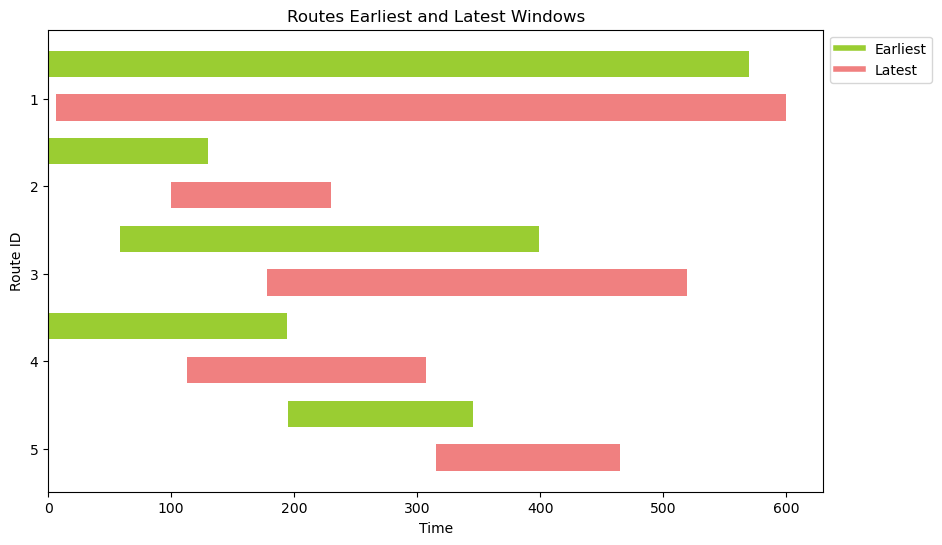

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
row_height = 0.3
row_space = 0.2

for _, row in routes.iterrows():
    route_id = row["Route ID"]
    earliest_start = row["Earliest Start Time"]
    earliest_end = row["Earliest End Time"]
    latest_start = row["Latest Start Time"]
    latest_end = row["Latest End Time"]

    # Plot the bars for earliest start to earliest end
    ax.barh(route_id - row_space / 2 - row_height, earliest_end - earliest_start, 
            left=earliest_start, height=row_height, color="yellowgreen")

    # Plot the bars for latest start to latest end on a separate line
    ax.barh(route_id + row_space / 2, latest_end - latest_start, 
            left=latest_start, height=row_height, color="lightcoral")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Route ID")
ax.set_title("Routes Earliest and Latest Windows")
ax.invert_yaxis()  # Invert the y-axis to have Route ID 1 at the top
# Set y-ticks to ensure integer values
ax.set_yticks(range(1, len(routes) + 1))
# Create a single legend entry 
earliest_legend = plt.Line2D([0], [0], color="yellowgreen", lw=4, label="Earliest")
latest_legend = plt.Line2D([0], [0], color="lightcoral", lw=4, label="Latest")
ax.legend(handles=[earliest_legend, latest_legend], loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

The length of each bar represents the duration from the start to the completion of a route. Because we have time windows (both earliest and latest times) for both the start and finish, each route is represented by two bars. One bar illustrates the route's duration if everything starts at the earliest times, and the other shows the duration if everything is delayed until the latest times. By comparing the starting points of these bars for each route, we can assess the schedule flexibility for each route.

We can see that some routes, like route 1, have a very tight schedule, while routes like 3 and 4, have more room for their start times. Our goal is now more clear. Is it possible to take advantage of the extra rooms in the routes' schedules and assign multiple routes to the same van, thus, reducing the number of resources?

In [4]:
order_routes = pd.read_csv('https://raw.githubusercontent.com/decision-spot/technician_assignment/main/orders.csv')
order_routes

,Route ID,Stop Number,Customer Name,Technician Name,Location Name,Job type,Processing Time,Customer Time Window Start,Customer Time Window End,Earliest Start,Latest Start,Earliest End,Latest End
0,1,1,Customer1,Albert,Mannheim,Equipment Setup,30.0,0.0,30.0,24.0,30.0,54.0,60.0
1,1,2,Customer7,Albert,Loerrach,Inspect/Service Equipment,60.0,360.0,480.0,360.0,390.0,420.0,450.0
2,2,1,Customer2,Bob,Karlsruhe,Equipment Setup,30.0,30.0,150.0,50.0,150.0,80.0,180.0
3,3,1,Customer4,Doris,Buehl,Equipment Installation,60.0,120.0,240.0,120.0,240.0,180.0,300.0
4,3,2,Customer6,Doris,Lahr/Schwarzwald,Repair - Critical,60.0,300.0,420.0,300.0,420.0,360.0,480.0
5,4,1,Customer3,Ed,Baden-Baden,Repair - Regular,60.0,60.0,180.0,67.0,180.0,127.0,240.0
6,5,1,Customer5,Flor,Offenburg,Equipment Installation,60.0,240.0,360.0,240.0,360.0,300.0,420.0


Note that "Earliest Start" and "Latest Start" consider the travel time from the Depot to the Customer. 

In [5]:
earliest_time = 0  # this is the reference for start time. Assume 7:00 AM is minute 0
latest_time = 600  # 10 hours later, 5:00 PM is minute 600
resource_limit = 3  # number of available resources

## Problem Formulation

Let's define our notations for the MO model.

**Sets**
- $O\quad$: Set of orders
- $R\quad$: Set of routes
- $V\quad$: Set of resources/vans

We also have the following information from `routes` and `order_routes` dataframes:

**Parameters**
- $b^{E}_{r}\quad$: earliest start (beginning) time of route $r \in R$
- $b^{L}_{r}\quad$: latest start (beginning) time of route $r \in R$
- $f^{E}_{r}\quad$: earliest end (finish) time of route $r \in R$
- $f^{L}_{r}\quad$: latest end (finish) time of route $r \in R$
- $t_{r}\quad$: total duration of time on route $r \in R$
- $a_{o,r}\quad$: 1 if order $o \in O$ is covered by route $r \in R$

Total time ($t_{r}$) includes all the transit time, processing time, and any waiting time from the start (leaving the depot) to the end (returning to the depot) for each route.

Note that superscript $E$ is used to indicate earliest and $L$ is used to indicate latest time. 

## Decision Variables

First of all, we know that due to resource limitation, we may not be able to use every route, and consequently, cover every order. So, we want to have variables that track the order coverage and route usage: 
- $u_{o}\quad$: 1 if order $o \in O$ is covered; 0 otherwise
- $x_{r}\quad$: 1 if route $r \in R$ is used; 0 otherwise

Next, we want to know which of the available vans are used and track which route is assigned to which van:
- $y_{r,v}\quad$: 1 if route $r \in R$ is assigned to van $v \in V$; 0 otherwise
- $z_{v}\quad$: 1 if van $v \in V$ is used; 0 otherwise

As explained before, we want to see if it's possible to take advantage of the route's start time flexibility and shift the routes around as needed. That way, more routes can be assigned to a single van. That means, the start time of a route (and by extension its end time) are decision variables too:
- $s_{r}\quad$: start time of route $r \in R$
- $e_{r}\quad$: end time of route $r \in R$

With these initial decision variables, we can start the MO model.

In [6]:
order_route_dict = dict(zip(order_routes['Customer Name'], order_routes['Route ID']))  # a(o,r)
routes_dict = routes.set_index('Route ID').to_dict(orient='index')  # this will help us in creating the constraints
r_set = routes_dict.keys()  # R
v_set = set(range(resource_limit))  # V
rv_set = {(r, v) for r in r_set for v in range(resource_limit)}  # pair of (r,v) index

In [8]:
mdl = gp.Model('resource_assignment')

# Variables
u = mdl.addVars(order_route_dict.keys(), vtype=GRB.BINARY, name='u')  # tracks whether order o is covered
x = mdl.addVars(r_set, vtype=GRB.BINARY, name='x')  # tracks whether route r is used
y = mdl.addVars(rv_set, vtype=GRB.BINARY, name='y')  # tracks whether route r is assigned to van v
z = mdl.addVars(v_set, vtype=GRB.BINARY, name='z')  # tracks whether van v is used
s = mdl.addVars(r_set, lb=earliest_time, ub=latest_time, vtype=GRB.CONTINUOUS, name='s')  # tracks start time of route r
e = mdl.addVars(r_set, lb=earliest_time, ub=latest_time, vtype=GRB.CONTINUOUS, name='e')  # tracks end time of route r

## Constraints

We know that each order is covered by one route and each route can have multiple orders. So, we first establish this relationship, ensuring that when an order is covered, the route that it belongs to should be used.

\begin{align}
&a_{o,r} x_{r} = u_{o} &\quad \forall o \in O, r \in R^o \tag{1}\\
\end{align}

Here, $R^o$, shows the routes that only cover order $o$.  
There are other ways to show this relationship in mathematical notation. For example, we can use the formulation below which is more generalizable for cases when there are multiple different routes that cover a given order.

\begin{align}
&\sum_{r} a_{o,r} x_{r} = u_{o} &\quad \forall o \in O \\
\end{align}

In [9]:
# Relation between x and u
for o, r in order_route_dict.items():
    mdl.addConstr(x[r] == u[o], f'order_cov_{o}'); # add ";" here to stop the cell to print the constraints

# # More generalizable version for cases when an order can be in multiple routes
# for o, routes in order_route_dict.items():  # in this case, order_route_dict has a signature of {order: list of routes}
#     mdl.addConstr(gp.quicksum(x[r] for r in routes) == u[o], f'order_cov_{o}')

Similarly, we know that if a route is used, it should be assigned to only one van:

\begin{align}
&\sum_{v} y_{r,v} = x_{r} &\quad \forall r \in R \tag{2}\\
\end{align}

In [10]:
# Relation between y and x
mdl.addConstrs((y.sum(r, '*') == x[r] for r in routes_dict), 'route_cov');

Next, we focus on van usage, i.e., $z_{v}$.
If a van is not used, no routes can be assigned to it. On the other hand, if a van is used, then at least one route should be assigned to it.

\begin{align}
&y_{r,v} \le z_{v} &\quad \forall r \in R, v \in V \tag{3}\\
\end{align}

\begin{align}
&\sum_{r} y_{r,v} \ge z_{v} &\quad \forall v \in V \tag{4}\\
\end{align}

In [11]:
# LB relation between y and z
mdl.addConstrs((y[r, v] <= z[v] for (r, v) in rv_set), 'lb_y_z')

# UB relation between y and z
mdl.addConstrs((y.sum('*', v) >= z[v] for v in v_set), 'ub_y_z');

Next, we establish the logical constraints for the route's start and end time.  
The start time of a route $r \in R$ ($s_r$) must be between the route's earliest and latest start time ($b^E_r$ and $b^L_r$, respectively).  
Similarly the end time of route $r \in R$ ($e_r$) must be between the route's earliest and latest end time ($f^E_r$ and $f^L_r$, respectively).  
Moreover, the route's start and end times have a relation with each other. Namely, the route's end time is equal to the route's start time plus the total duration.

\begin{align}
&b^{E}_{r} \le s_{r} \le b^{L}_{r} &\quad \forall r \in R \tag{5}\\
&f^{E}_{r} \le e_{r} \le f^{L}_{r} &\quad \forall r \in R \tag{6}\\
&s_{r} + t_{r} = e_{r} &\quad \forall r \in R \tag{7}
\end{align}

**Note**  
$s_r$ and $e_r$ only assume meaningful values for routes that are used (i.e., for routes where $x_r = 1$). 



In [12]:
# LB of s
mdl.addConstrs((s[r] >= routes_dict[r]['Earliest Start Time'] for r in r_set), 'lb_s')

# UB of s
mdl.addConstrs((s[r] <= routes_dict[r]['Latest Start Time']  for r in r_set), 'ub_s')

# LB of e
mdl.addConstrs((e[r] >= routes_dict[r]['Earliest End Time'] for r in r_set), 'lb_e')

# UB of e
mdl.addConstrs((e[r] <= routes_dict[r]['Latest End Time'] for r in r_set), 'ub_e')

# relation between s and e
mdl.addConstrs((s[r] + routes_dict[r]['Total Time'] == e[r]  for r in r_set), 'rel_s_e');

We need another set of constraints to establish the relationship between different routes assigned to a van. Without these constraints, nothing stops the model from assigning all the routes to one van.

For any two routes, if one of them is assigned to a van, the other route can only be assigned to the same van if either its start time occurs after the end time of the first route or its end time occurs before the start time of the first route.

Using indexes of $r \in R$ and $h \in R$ to refer to any two routes ($r \ne h$), we need a way to say:

For all $r \in R$ and $h \in R$ ($r \neq h$), if there exists $v \in V$ such that $y_{r,v} = 1$ and $y_{h,v} = 1$, then either $s_h \geq e_r$ or $s_r \geq e_h$.

In other words, we want to say:
- If two routes $r$ and $h$ are both assigned to the same van, then only one of the two constraints should be active
- If neither route $r$ nor route $h$ are assigned to the same van, the constraints should be inactive

Because we have an "Either-Or" structure between the two constraints, we use an indicator variable that when takes a value of 1, activates the first constraints and if it takes a value of 0, activates the second constraint. Let's call this indicator variable $\delta_{r,h}$ and define it as follows:

- $\delta_{r,h}\quad$: A binary variable equal to 1 if route $r \in R$ and $h \in R$ are served by the same van **and route $r$ comes before route $h$**


With the definition of $\delta_{r,h}$, we can simplify our logic as follows:
\begin{align}
\text{if} \quad \delta_{r,h} = 1 \rightarrow s_h \ge e_r \quad \forall r \in R, h \in R: r < h \\
\text{if} \quad \delta_{h,r} = 1 \rightarrow s_r \ge e_h \quad \forall r \in R, h \in R: r < h
\end{align}

Now, using the **BigM method** we can write these constraints:

\begin{align}
  s_h \ge e_r - M(1 - \delta_{r,h}) \quad \forall r \in R, h \in R : r < h \tag{8}\\
  s_r \ge e_h - M(1 - \delta_{h,r}) \quad \forall r \in R, h \in R : r < h \tag{9}\\
\end{align}

Moreover, we write the constraint that defines $\delta$ based on $y$:

\begin{align}
y_{r,v} + y_{h,v} - 1 \leq \delta_{r,h} + \delta_{h,r} \quad \forall r \in R, h \in R, v \in V: r < h \tag{10}\\
\end{align}

This constraint says that if there exists $v \in V$ such that $y_{r,v} = y_{h,v} = 1$, then either $\delta_{r,h}$ or $\delta_{h,r}$ will be forced to equal $1$.  

**Constraints Analysis**:  

Consider any two routes $r,h \in R$ and suppose they are both assigned to van $v \in V$. If $\delta_{r,h} = 1$ (and consequently, $\delta_{h,r} = 0$), that should mean route $r$ comes before route $h$. In this case, the first two constraints reduce to: 

\begin{align}
  s_h \ge e_r  \quad \forall r \in R, h \in R : r < h \\
  s_r \ge e_h - M \quad \forall r \in R, h \in R : r < h \\
\end{align}

The first constraint simply says that route $h$ should start after route $r$ finishes, which is what we want.  
The second constraint has a large negative right-hand-side which makes it non-binding, ineffective, or redundant.

Note that these two constraints, along with constraint 7, also ensure that both $\delta_{r,h}$ and $\delta_{h,r}$ don't take a value of 1 simultaneously. Because it's not possible for the start of route $h$ to be after end of route $r$ and also, end of route $h$ be before the start of route $r$.

Similarly, if neither route $r$ or $h$ are assigned to van $v$, then both of those constraints are non-binding due to large values of $M$.

In [13]:
rh_set = set((r1, r2) for r1 in r_set for r2 in r_set if r1 != r2)  # pair of (r,h) index

In [14]:
delta = mdl.addVars(rh_set, vtype=GRB.BINARY, name='d')

In [15]:
# Relation between any pair of routes assigned to a van
big_m = latest_time
for (r, h) in rh_set:
    if r < h:
        mdl.addConstr(s[h] >= e[r] - big_m * (1 - delta[r, h]), f'rbh_{r}_{h}')  # r before h
        mdl.addConstr(s[r] >= e[h] - big_m * (1 - delta[h, r]), f'hbr_{r}_{h}')  # h before r
        
        for v in v_set:
            mdl.addConstr(y[r, v] + y[h, v] - 1 <= delta[r, h] + delta[h, r], f'rel_d_y_{r}_{h}_{v}')

There is an alternative way to write the above constraints with the $M$ terms, taking advantage of gurobi's syntax.
We can simply tell gurobi that the constraints should only be valid if the respective $\delta$ variable takes a value of 1. Namely:

In [16]:
for (r, h) in rh_set:
    if r < h:
        mdl.addConstr((delta[r,h] == 1) >> (s[h] >= e[r]), f'rbh_{r}_{h}')  # r before h
        mdl.addConstr((delta[h,r] == 1) >> (s[r] >= e[h]), f'hbr_{r}_{h}')  # h before r
        # only repeating the constraint below, in case you want to try the model by running this cell instead of the one above
        for v in v_set:
            mdl.addConstr(y[r, v] + y[h, v] - 1 <= delta[r, h] + delta[h, r], f'rel_d_y_{r}_{h}_{v}')

**NOTE: Either run the cells with BigM formulation or the above one with the indicator variables, not both.**

**Tip**:
Even though the BigM method is generic, Gurobi's syntax has two advantages over the traditional BigM method.
1. In most cases, it's more intuitive since the syntax is closer to how we think about the constraints.
2. In large problems, it performs better since Gurobi can extract a much tighter BigM value(s) based on the structure of the model.
  - _Extra_: Gurobi could reformulate indicator constraints into [SOS1 constraints](https://www.gurobi.com/documentation/current/refman/constraints.html#subsubsection:SOSConstraints) or BigM constraints. It depends on the $M$ Gurobi is given (or able to derive).

## Objectives

In this model, we have two objectives:
1. Maximize order coverage
2. Minimize resource/van usage

\begin{align}
\max \sum_{o} u_{o}\\
\min \sum_{v} z_{v}\\
\end{align}

We want to give a higher priority to the first objective. To use gurobi's multi-objective syntax, we can have one sense (i.e., minimize or maximize). This is easy since $\max f(x) = \min - f(x)$

In [17]:
mdl.ModelSense = GRB.MINIMIZE
# weight=1: minimize, -1: maximize
mdl.setObjectiveN(u.sum(), index=0, priority=2, name='order_coverage', weight=-1)
mdl.setObjectiveN(z.sum(), index=1, priority=1, name='resource_usage', weight=1)

We can now tell Gurobi that the model is complete and it can solve the problem.

In [18]:
# mdl.write('ra.lp')
mdl.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 135 rows, 60 columns and 412 nonzeros
Model fingerprint: 0xb260da79
Model has 20 general constraints
Variable types: 10 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 6e+02]
  GenCon coe range [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 86 rows and 9 columns
Presolve time: 

## Post Processing

In [19]:
res_df = pd.DataFrame()
status = mdl.status
if status == GRB.OPTIMAL:
    res_list = []
    for k, val in y.items():
        if val.x > 0.5:
            rid, n = k  # route id, resource number
            r = routes_dict[rid]
            st = s[rid].x  # start time
            rows = {'Resource Number': n, 'Route Number': rid, 'Start Time': st}
            rows.update(r)
            res_list.append(rows)
    res_df = pd.DataFrame(res_list)
    res_df = res_df.sort_values(by=['Resource Number', 'Start Time', 'Route Number'])
    uncovered_orders = {o for o in order_route_dict if u[o].x < 0.5}
    print(f'Uncovered orders: {uncovered_orders}') if uncovered_orders else print('All Covered!')
elif status in (GRB.INF_OR_UNBD, GRB.INFEASIBLE):
    print('Model is either infeasible or unbounded.')
else:
    print(f'Status is {status} which is unexpected.')
res_df

All Covered!


,Resource Number,Route Number,Start Time,Technician Name,Origin Location,Total Travel Time,Total Processing Time,Total Time,Earliest Start Time,Latest Start Time,Earliest End Time,Latest End Time,Num Jobs
1,0,4,0.0,Ed,Heidelberg,134.0,60.0,194.0,0.0,113.0,194.0,307.0,1
4,0,5,315.0,Flor,Freiburg im Breisgau,90.0,60.0,150.0,195.0,315.0,345.0,465.0,1
2,1,2,0.0,Bob,Heidelberg,100.0,30.0,130.0,0.0,100.0,130.0,230.0,1
3,1,3,178.0,Doris,Freiburg im Breisgau,141.0,120.0,341.0,58.0,178.0,399.0,519.0,2
0,2,1,0.0,Albert,Heidelberg,334.0,90.0,570.0,0.0,6.0,570.0,600.0,2


## Putting it all together

**Sets**
- $O\quad$: Set of orders
- $R\quad$: Set of routes
- $V\quad$: Set of resources/vans

**Parameters**
- $b^{E}_{r}\quad$: earliest start time of route $r$
- $b^{L}_{r}\quad$: latest start time of route $r$
- $f^{E}_{r}\quad$: earliest end time of route $r$
- $f^{L}_{r}\quad$: latest end time of route $r$
- $t_{r}\quad$: total duration of time on route $r$
- $a_{o,r}\quad$: 1 if order $o$ is covered by route $r$

**Variables**
- $u_{o}\quad$: 1 if order $o$ is covered; 0 otherwise
- $x_{r}\quad$: 1 if route $r$ is used; 0 otherwise
- $y_{r,v}\quad$: 1 if route $r$ is assigned to van $v$; 0 otherwise
- $z_{v}\quad$: 1 if van $v$ is used; 0 otherwise
- $s_{r}\quad$: start time of route $r \in R$
- $e_{r}\quad$: end time of route $r \in R$
- $\delta_{r,h}\quad$: 1 if and only if route $r$ and $h$ are served by the same van <u>and route $r$ comes before route $h$</u>; 0 otherwise

\begin{align}
&\max \sum_{o} u_{o}&\\
&\min \sum_{v} z_{v}&\\
\mbox{s.t: }\\
&\sum_{r} a_{o,r} x_{r} = u_{o} &\quad \forall o \in O \tag{1}\\
&\sum_{v} y_{r,v} = x_{r} &\quad \forall r \in R \tag{2}\\
&y_{r,v} \le z_{v} &\quad \forall r \in R, v \in V \tag{3}\\
&\sum_{r} y_{r,v} \ge z_{v} &\quad \forall v \in V \tag{4}\\
&b^{E}_{r} \le s_{r} \le b^{L}_{r} &\quad \forall r \in R \tag{5}\\
&f^{E}_{r} \le e_{r} \le f^{L}_{r} &\quad \forall r \in R \tag{6}\\
&s_{r} + t_{r} = e_{r} &\quad \forall r \in R \tag{7}\\
&s_h \ge e_r - M(1 - \delta_{r,h}) &\quad \forall r \in R, h \in R : r < h \tag{8}\\
&s_r \ge e_h - M(1 - \delta_{h,r}) &\quad \forall r \in R, h \in R : r < h \tag{9}\\
&y_{r,v} + y_{h,v} - 1 \leq \delta_{r,h} + \delta_{h,r} &\quad \forall r \in R, h \in R, v \in V: r < h \tag{10}\\
&u_{o}, x_{r}, y_{r,v}, z_{v}, \delta_{r,h} \in \{0,1\} &\quad \forall o \in O, r,h \in R, v \in V\tag{11}\\
&s_{r}, e_{r} \ge 0  &\quad \forall r \in R \tag{12}\\
\end{align}

In [20]:
def resource_assignment(routes, order_routes, resource_limit):
    order_route_dict = dict(zip(order_routes['Customer Name'], order_routes['Route ID']))  # a(o,r)
    routes_dict = routes.set_index('Route ID').to_dict(orient='index')  # this will help us in creating the constraints
    r_set = routes_dict.keys()  # R
    v_set = set(range(resource_limit))  # V
    rv_set = {(r, v) for r in r_set for v in range(resource_limit)}  # pair of (r,v) index
    rh_set = set((r1, r2) for r1 in r_set for r2 in r_set if r1 != r2)  # pair of (r,h) index

    mdl = gp.Model('resource_assignment')

    # Variables
    u = mdl.addVars(order_route_dict.keys(), vtype=GRB.BINARY, name='u')
    x = mdl.addVars(routes_dict.keys(), vtype=GRB.BINARY, name='x')
    y = mdl.addVars(rv_set, vtype=GRB.BINARY, name='y')
    z = mdl.addVars(v_set, vtype=GRB.BINARY, name='z')
    s = mdl.addVars(r_set, lb=earliest_time, ub=latest_time, vtype=GRB.CONTINUOUS, name='s')
    e = mdl.addVars(r_set, lb=earliest_time, ub=latest_time, vtype=GRB.CONTINUOUS, name='e')
    delta = mdl.addVars(rh_set, vtype=GRB.BINARY, name='d')
    
    # Constraints
    # Relation between x and u
    for o, r in order_route_dict.items():
        mdl.addConstr(x[r] == u[o], f'order_cov_{o}')
        
    # Relation between y and x
    mdl.addConstrs((y.sum(r, '*') == x[r] for r in routes_dict), 'route_cov')
    
    # LB relation between y and z
    mdl.addConstrs((y[r, v] <= z[v] for (r, v) in rv_set), 'lb_y_z')

    # UB relation between y and z
    mdl.addConstrs((y.sum('*', v) >= z[v] for v in v_set), 'ub_y_z')
    
    # LB of s
    mdl.addConstrs((s[r] >= routes_dict[r]['Earliest Start Time'] for r in r_set), 'lb_s')

    # UB of s
    mdl.addConstrs((s[r] <= routes_dict[r]['Latest Start Time']  for r in r_set), 'ub_s')

    # LB of e
    mdl.addConstrs((e[r] >= routes_dict[r]['Earliest End Time'] for r in r_set), 'lb_e')

    # UB of e
    mdl.addConstrs((e[r] <= routes_dict[r]['Latest End Time'] for r in r_set), 'ub_e')

    # relation between s and e
    mdl.addConstrs((s[r] + routes_dict[r]['Total Time'] == e[r]  for r in r_set), 'rel_s_e')
    
    # Relation between any pair of routes assigned to a van
    for (r, h) in rh_set:
        if r < h:
            mdl.addConstr((delta[r,h] == 1) >> (s[h] >= e[r]), f'rbh_{r}_{h}')  # r before h
            mdl.addConstr((delta[h,r] == 1) >> (s[r] >= e[h]), f'hbr_{r}_{h}')  # h before r
            for v in v_set:
                mdl.addConstr(y[r, v] + y[h, v] - 1 <= delta[r, h] + delta[h, r], f'rel_d_y_{r}_{h}_{v}')

    # Objectives
    mdl.ModelSense = GRB.MINIMIZE
    # weight=1: minimize, -1: maximize
    mdl.setObjectiveN(u.sum(), index=0, priority=2, name='order_coverage', weight=-1)
    mdl.setObjectiveN(z.sum(), index=1, priority=1, name='resource_usage', weight=1)
    mdl.setParam(GRB.Param.OutputFlag, 0)  # disable printing the logs
    mdl.optimize()

    # create output
    res_df = pd.DataFrame()
    status = mdl.status
    if status == GRB.OPTIMAL:
        res_list = []
        for k, val in y.items():
            if val.x > 0.5:
                rid, n = k  # route id, resource number
                r = routes_dict[rid]
                st = s[rid].x  # start time
                rows = {'Resource Number': n, 'Route Number': rid, 'Start Time': st}
                rows.update(r)
                res_list.append(rows)
        res_df = pd.DataFrame(res_list)
        res_df = res_df.sort_values(by=['Resource Number', 'Start Time', 'Route Number'])
        uncovered_orders = {o for o in order_route_dict if u[o].x < 0.5}
        print(f'Uncovered orders: {uncovered_orders}') if uncovered_orders else print('All Covered!')
    elif status in (GRB.INF_OR_UNBD, GRB.INFEASIBLE):
        print('Model is either infeasible or unbounded.')
    else:
        print(f'Status is {status} which is unexpected.')
    return res_df

In [21]:
# run the model with different resource limits
all_outputs = []
for limit in range(1,5):
    print(f'**************\nRunning the model with {limit} vans\n**************')
    res = resource_assignment(routes, order_routes, limit)
    res['Resource Limit'] = limit
    all_outputs.append(res)
output_df = pd.concat(all_outputs)
output_df = output_df[["Resource Limit"] + [col for col in output_df.columns if col != "Resource Limit"]]

**************
Running the model with 1 vans
**************
Uncovered orders: {'Customer7', 'Customer5', 'Customer3', 'Customer1'}
**************
Running the model with 2 vans
**************
Uncovered orders: {'Customer5', 'Customer3'}
**************
Running the model with 3 vans
**************
All Covered!
**************
Running the model with 4 vans
**************
All Covered!


In [22]:
output_df

,Resource Limit,Resource Number,Route Number,Start Time,Technician Name,Origin Location,Total Travel Time,Total Processing Time,Total Time,Earliest Start Time,Latest Start Time,Earliest End Time,Latest End Time,Num Jobs
0,1,0,2,0.0,Bob,Heidelberg,100.0,30.0,130.0,0.0,100.0,130.0,230.0,1
1,1,0,3,178.0,Doris,Freiburg im Breisgau,141.0,120.0,341.0,58.0,178.0,399.0,519.0,2
1,2,0,2,0.0,Bob,Heidelberg,100.0,30.0,130.0,0.0,100.0,130.0,230.0,1
2,2,0,3,178.0,Doris,Freiburg im Breisgau,141.0,120.0,341.0,58.0,178.0,399.0,519.0,2
0,2,1,1,0.0,Albert,Heidelberg,334.0,90.0,570.0,0.0,6.0,570.0,600.0,2
0,3,0,4,0.0,Ed,Heidelberg,134.0,60.0,194.0,0.0,113.0,194.0,307.0,1
2,3,0,5,315.0,Flor,Freiburg im Breisgau,90.0,60.0,150.0,195.0,315.0,345.0,465.0,1
1,3,1,1,0.0,Albert,Heidelberg,334.0,90.0,570.0,0.0,6.0,570.0,600.0,2
3,3,2,2,0.0,Bob,Heidelberg,100.0,30.0,130.0,0.0,100.0,130.0,230.0,1
4,3,2,3,178.0,Doris,Freiburg im Breisgau,141.0,120.0,341.0,58.0,178.0,399.0,519.0,2


# Further Practice: Model Enhancement
Make the following changes to the model:
- Considering the the input files, the output dataframe is not correct. Can you spot what's wrong about it?
  - _Hint_: The fix is very easy and you don't need to change the mathematical model!
  - **Answer**: I did nothing about the depots. Technicians are not all stationed at the same depot. Since each depot is independent, we just need to decompose the input data based on depot and run the orders and routes of each depot separately.
- Some orders are more important (maybe they are from the premium users) and should be favored.
  - **Answer**: Introduce a priority parameter for each order. Then, change the objective function so that rather than $\sum_{o} u_{o}$ we have $\sum_{o} p_{o} u_{o}$ where $p_{o}$ is the priority of order $o \in O$.